In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

current_palette = sns.color_palette(("#000000",))
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(10,4)}, font_scale=1.25, style='whitegrid', font='CMU Serif')

def save_fig(ax, folder, suffix, format=".pdf"):
    fig = ax.get_figure()
    fig.tight_layout()

    fig.savefig(folder + suffix + format)
    fig.clear()

In [2]:
top_df = pd.read_csv("top_results.csv")
top_df["Time"] = pd.to_datetime(top_df["t"])
top_df["Time"] = top_df["Time"] - top_df["Time"].min()
top_df["Time"] = top_df["Time"].dt.total_seconds().astype(int)
top_df["cpu_norm"] = top_df["cpu"] / 32.0
top_df["Process"] = top_df.apply((lambda x: "Firecracker microVM" if x["type"] == "microVM" else "Machine Manager"), axis=1)
top_df

,t,cpu,mem,type,name,Time,cpu_norm,Process
0,11:57:58,0.0,0.1,celestial,NaN,0,0.0,Machine Manager
1,11:57:59,0.0,0.1,celestial,NaN,1,0.0,Machine Manager
2,11:58:00,0.0,0.1,celestial,NaN,2,0.0,Machine Manager
3,11:58:01,0.0,0.1,celestial,NaN,3,0.0,Machine Manager
4,11:58:02,0.0,0.1,celestial,NaN,4,0.0,Machine Manager
...,...,...,...,...,...,...,...,...
47939,12:14:33,0.0,0.2,microVM,3-38,995,0.0,Firecracker microVM
47940,12:14:33,0.0,0.2,microVM,2-239,995,0.0,Firecracker microVM
47941,12:14:33,0.0,0.2,microVM,0-791,995,0.0,Firecracker microVM
47942,12:14:33,0.0,0.2,microVM,0-941,995,0.0,Firecracker microVM


<AxesSubplot:xlabel='t [s]', ylabel='CPU Core Usage %'>

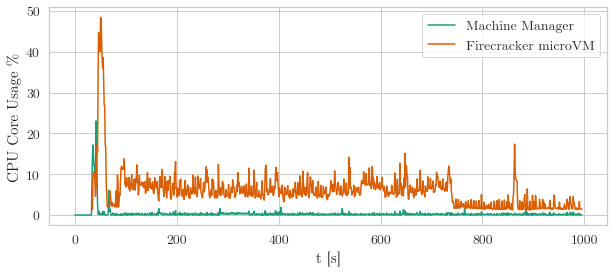

In [3]:
ax_top = sns.lineplot(x="Time", y="cpu_norm", data=top_df[top_df["type"] != "other"], hue="Process", palette=sns.color_palette("Dark2", n_colors=2), estimator=np.sum, ci=None)
ax_top.set_ylabel("CPU Core Usage %")
ax_top.set_xlabel("t [s]")
handles, labels = ax_top.get_legend_handles_labels()
ax_top.legend(handles=handles[0:], labels=labels[0:])
#save_fig(ax_top, "../../graphs/paper/", "cpu_usage")
ax_top

<AxesSubplot:xlabel='t [s]', ylabel='Memory Usage %'>

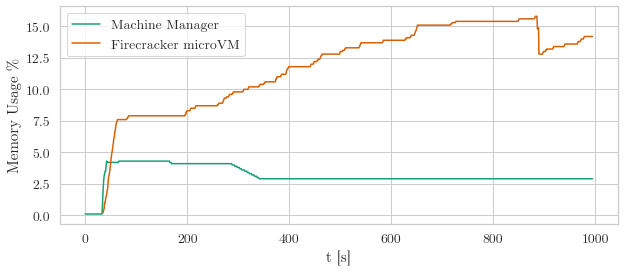

In [4]:
ax_top_mem = sns.lineplot(x="Time", y="mem", data=top_df[top_df["type"] != "other"], hue="Process", palette=sns.color_palette("Dark2", n_colors=2), estimator=np.sum, ci=None)
ax_top_mem.set_ylabel("Memory Usage %")
ax_top_mem.set_xlabel("t [s]")
handles, labels = ax_top_mem.get_legend_handles_labels()
ax_top_mem.legend(handles=handles[0:], labels=labels[0:])
#save_fig(ax_top_mem, "../../graphs/paper/", "mem_usage")
ax_top_mem

In [5]:
vmstat_df = pd.read_csv("vmstat.csv")
vmstat_df["Time"] = pd.to_datetime(vmstat_df["t"])
vmstat_df["Time"] = vmstat_df["Time"] - vmstat_df["Time"].min()
vmstat_df["Time"] = vmstat_df["Time"].dt.total_seconds().astype(int)
vmstat_df

,t,free_mem,cpu,Time
0,11:57:41,28101292,0,0
1,11:57:42,28101544,0,1
2,11:57:43,28101544,0,2
3,11:57:44,28101544,0,3
4,11:57:45,28101544,0,4
...,...,...,...,...
1017,12:14:38,24079476,0,1017
1018,12:14:39,24083816,0,1018
1019,12:14:40,24083820,0,1019
1020,12:14:41,24083968,0,1020


In [75]:
ax_vmstat = sns.lineplot(x="Time", y="cpu", data=vmstat_df[(vmstat_df["Time"] < 600)], color="#444444", ci=None)
ax_vmstat.set_ylabel("Total Host CPU Usage %")
ax_vmstat.set_xlabel("t [s]")
save_fig(ax_vmstat, "../../graphs/website/efficiency/", "total_cpu_usage", format=".png")
ax_vmstat

<AxesSubplot:>

<Figure size 720x288 with 0 Axes>

In [6]:
vm_count = pd.DataFrame(dict(Counter(top_df[top_df["type"] == "microVM"]["Time"])), index=[0]).T
#vm_count.reset_index(inplace=True)
#vm_count.insert(0, range(0, vm_count.index.max()))
vm_count["Time"] = vm_count.index
vm_count.insert(2, "X", "x")
vm_count.columns = ["# Firecracker Processes", "Time", "X"]
vm_count

,# Firecracker Processes,Time,X
35,2,35,x
36,4,36,x
37,4,37,x
38,6,38,x
39,6,39,x
...,...,...,...
991,69,991,x
992,69,992,x
993,69,993,x
994,69,994,x


In [7]:
fig, ax = plt.subplots()
fig = sns.lineplot(x="Time", y="cpu_norm", data=top_df[(top_df["type"] != "other") & (top_df["Time"] < 600)], hue="Process", palette=sns.color_palette("Dark2", n_colors=2), estimator=np.sum, ci=None, ax=ax)
fig.set_ylabel("CPU Core Usage %")
fig.set_xlabel("t [s]")

#save_fig(ax_top, "../../graphs/paper/", "cpu_usage")
ax2 = ax.twinx()
fig2 = sns.lineplot(x="Time", y="# Firecracker Processes", data=vm_count[(vm_count["Time"] < 600)], ax=ax2, hue="X", color="#7570b3")
handles, labels = fig.get_legend_handles_labels()
fig2.grid(None)
fig.set_ylim(-2, 62)
fig2.set_ylim(-2, 62)

h1,l1 = fig.get_legend_handles_labels()
h2,l2 = fig2.get_legend_handles_labels()
ax.legend(loc="center right", handles=h1+h2, labels = l1+["# Firecracker Processes"])
ax2.get_legend().remove()
save_fig(ax, "../../graphs/paper/", "cpu_usage")

<Figure size 720x288 with 0 Axes>

In [9]:
fig, ax = plt.subplots()
fig = sns.lineplot(x="Time", y="mem", data=top_df[(top_df["type"] != "other") & (top_df["Time"] < 600)], hue="Process", palette=sns.color_palette("Dark2", n_colors=2), estimator=np.sum, ci=None, ax=ax)
fig.set_ylabel("Memory Usage %")
fig.set_xlabel("t [s]")

#save_fig(ax_top, "../../graphs/paper/", "cpu_usage")
ax2 = ax.twinx()
fig2 = sns.lineplot(x="Time", y="# Firecracker Processes", data=vm_count[(vm_count["Time"] < 600)], ax=ax2, hue="X", color="#7570b3")
handles, labels = fig.get_legend_handles_labels()
fig2.grid(None)
fig.set_ylim(-0.40, 16.4)
fig2.set_ylim(-1.6, 65.6)

h1,l1 = fig.get_legend_handles_labels()
h2,l2 = fig2.get_legend_handles_labels()
ax.legend(loc="upper left", handles=h1+h2, labels = l1+["# Firecracker Processes"])
ax2.get_legend().remove()
save_fig(ax, "../../graphs/paper/", "mem_usage")

<Figure size 720x288 with 0 Axes>

In [79]:
top_df[(top_df["type"] == "celestial") & (top_df["Time"]> 100)]

,t,cpu,mem,type,name,Time,cpu_norm,Process
1778,11:59:39,0.0,4.3,celestial,NaN,101,0.000000,Machine Manager
1788,11:59:40,14.7,4.3,celestial,NaN,102,0.459375,Machine Manager
1841,11:59:41,0.0,4.3,celestial,NaN,103,0.000000,Machine Manager
1849,11:59:42,10.8,4.3,celestial,NaN,104,0.337500,Machine Manager
1902,11:59:43,0.0,4.3,celestial,NaN,105,0.000000,Machine Manager
...,...,...,...,...,...,...,...,...
47607,12:14:29,2.0,2.9,celestial,NaN,991,0.062500,Machine Manager
47664,12:14:30,3.9,2.9,celestial,NaN,992,0.121875,Machine Manager
47767,12:14:31,0.0,2.9,celestial,NaN,993,0.000000,Machine Manager
47836,12:14:32,0.0,2.9,celestial,NaN,994,0.000000,Machine Manager


In [80]:
sns.set(rc={'figure.figsize':(20,4)}, style='whitegrid', font='CMU Serif')

In [81]:
fig, ax = plt.subplots()
fig = sns.lineplot(x="Time", y="mem", data=top_df[(top_df["type"] != "other") & (top_df["Time"] < 600)], hue="Process", palette=sns.color_palette("Dark2", n_colors=2), estimator=np.sum, ci=None, ax=ax)
fig.set_ylabel("Memory Usage %")
fig.set_xlabel("t [s]")

#save_fig(ax_top, "../../graphs/paper/", "cpu_usage")
ax2 = ax.twinx()
fig2 = sns.lineplot(x="Time", y="# Firecracker Processes", data=vm_count[(vm_count["Time"] < 600)], ax=ax2, hue="X", color="#7570b3")
handles, labels = fig.get_legend_handles_labels()
fig2.grid(None)
fig.set_ylim(-0.40, 16.4)
fig2.set_ylim(-2, 82)

h1,l1 = fig.get_legend_handles_labels()
h2,l2 = fig2.get_legend_handles_labels()
ax.legend(loc="upper left", handles=h1+h2, labels = l1+["# Firecracker Processes"])
ax2.get_legend().remove()
save_fig(ax, "../../graphs/website/efficiency/", "mem_usage", format=".png")

<Figure size 1440x288 with 0 Axes>

In [82]:
fig, ax = plt.subplots()
fig = sns.lineplot(x="Time", y="cpu_norm", data=top_df[(top_df["type"] != "other") & (top_df["Time"] < 600)], hue="Process", palette=sns.color_palette("Dark2", n_colors=2), estimator=np.sum, ci=None, ax=ax)
fig.set_ylabel("CPU Core Usage %")
fig.set_xlabel("t [s]")

#save_fig(ax_top, "../../graphs/paper/", "cpu_usage")
ax2 = ax.twinx()
fig2 = sns.lineplot(x="Time", y="# Firecracker Processes", data=vm_count[(vm_count["Time"] < 600)], ax=ax2, hue="X", color="#7570b3")
handles, labels = fig.get_legend_handles_labels()
fig2.grid(None)
fig.set_ylim(-2, 62)
fig2.set_ylim(-2, 62)

h1,l1 = fig.get_legend_handles_labels()
h2,l2 = fig2.get_legend_handles_labels()
ax.legend(loc="center right", handles=h1+h2, labels = l1+["# Firecracker Processes"])
ax2.get_legend().remove()
save_fig(ax, "../../graphs/website/efficiency/", "cpu_usage", format=".png")

<Figure size 1440x288 with 0 Axes>